In [1]:
% matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pltparams = {'legend.fontsize': 16, 'axes.labelsize': 20, 'axes.titlesize': 20,
            'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize': (7.5, 7.5)}
plt.rcParams.update(pltparams)

In [3]:
# Logarithmic return of price time series
def logreturn(St,tau=1):
    return np.log(St[tau:])-np.log(St[0:-tau]) # Eq.(J2) : G_tau(t) = log(S(t+tau)) - log(S(t)) 

# normalize data to have unit variance (<(x - <x>)^2> = 1)
def normalized(data):
    return ((data)/np.sqrt(np.var(data)))

# compute normalized probability distribution function
def pdf(data,bins=50):
    hist,edges=np.histogram(data[~np.isnan(data)],bins=bins,density=True) # remove NaNs and compute histogram
    edges   = (edges[:-1] + edges[1:])/2.0 # get bar center
    nonzero = hist > 0.0                   # non-zero points 
    return edges[nonzero], hist[nonzero]

In [5]:
params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2} # define model parameters

def model1RW(params,p0):                # simulate Random-Walk for 1 transaction
    price = np.array([p0[0], p0[1]])    # initialize mid-prices for dealers p_1 and p_2
    cdp   = params['c']*params['dp']    # define random step size
    Dt    = [price[0]-price[1]]         # initialize price difference as empty list
    At    = [np.average(price)]         # initialize avg price as empy list
    
    while np.abs(price[0]-price[1]) < params['L']:
        price=price+np.random.choice([-cdp,cdp],size=2) # random walk step for mid-prices Eq. (K2)
        Dt.append(price[0]-price[1])
        At.append(np.average(price))
    
    return np.array(Dt),np.array(At)-At[0] # return difference array and average centered at zero

Walk  0  : number of steps =  9248 , price change =  -0.00270000000009
Walk  1  : number of steps =  2201 , price change =  0.00340000000011
Walk  2  : number of steps =  1629 , price change =  0.00280000000009


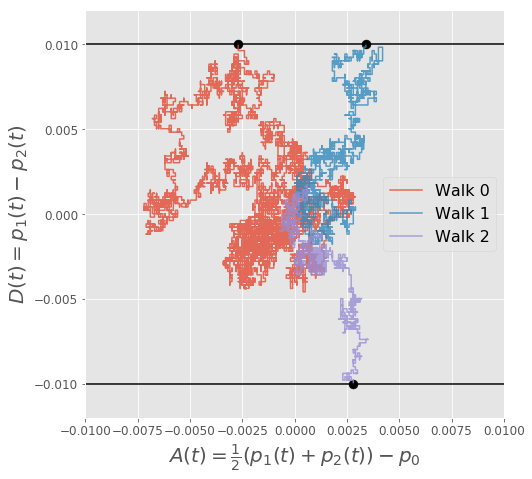

In [6]:
np.random.seed(123456)

fig,ax=plt.subplots(figsize=(7.5,7.5),subplot_kw={'xlabel':r'$A(t) = \frac{1}{2}\left(p_1(t) + p_2(t)\right) - p_0$', 'ylabel':r'$D(t) = p_1(t) - p_2(t)$'})

p0 = [100.25, 100.25]

for i in range(3):
    Dt,At = model1RW(params, p0)
    ax.plot(At,Dt,alpha=0.8,label='Walk '+str(i)) #plot random walk trajectory
    ax.scatter(At[-1],Dt[-1],marker='o',s=80,color='k') #last point
    print('Walk ', i,' : number of steps = ',len(At),', price change = ', At[-1])

ax.plot([-0.01,0.03],[params['L'],params['L']],color='k') #top absorbing boundary P=L
ax.plot([-0.01,0.03],[-params['L'],-params['L']],color='k') #bottom absorbing boundary P=-L
ax.set_ylim([-0.012, 0.012])
ax.set_xlim([-0.01, 0.01])
ax.legend(loc=5,framealpha=0.8)

plt.show()

In [8]:
params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2} # define model parameters

def model1(params,p0,numt):                # simulate dealer model for numt ticks
    mktprice = np.zeros(numt)              # initialize array for market prices
    ticktime = np.zeros(numt,dtype=np.int) # initialize array for tick times
    price    = np.array([p0[0], p0[1]])    # initailize dealer's mid-price (p1,p2)
    time,tick = 0,0                        # real time (t) and tick time (n)
    cdp      = params['c']*params['dp']    # define random step size
    
    while tick < numt:                     # loop over ticks
        while np.abs(price[0]-price[1])< params['L']: # perform one RW for each transaction
            price=price+np.random.choice([-cdp,cdp],size=2) # random walk step Eq. (K2)
            time += 1 # update time t
        price[:] = np.average(price)       # set mid-prices to new market price Eq. (K3)
        mktprice[tick] = price[0]          # save market price
        ticktime[tick] = time              # save tick time
        tick += 1                          # updat ticks
    
    return ticktime,mktprice   

In [9]:
#4 minutes to run
#np.random.seed(0)
#ticktime,mktprice=model1(params,[100.25,100.25],5000)
#np.savetxt('model1.txt',np.transpose([ticktime,mktprice]))

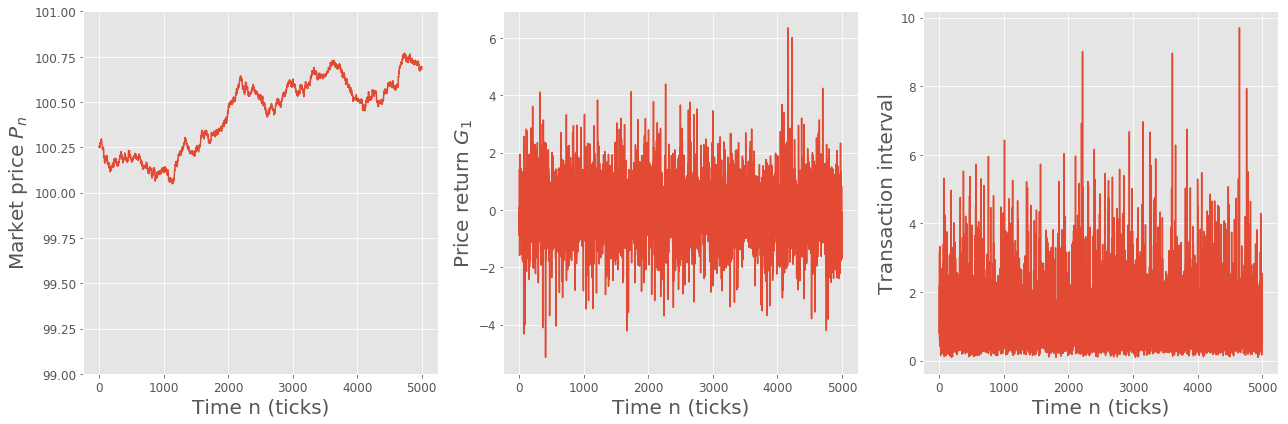

In [10]:
ticktime,mktprice=np.loadtxt('model1.txt',unpack=True) # read saved data from file
timeinterval=normalized((ticktime[1:]-ticktime[0:-1])*params['dt']) # compute time difference between subsequent trades
dprice=normalized(logreturn(mktprice,1)) # compute logarithmic return of the price over one tick, normalized to have unit variance (Eq. J2)

fig,[ax,bx,cx]=plt.subplots(figsize=(18,6),ncols=3,subplot_kw={'xlabel':r'Time n (ticks)'})

ax.plot(mktprice)
ax.set_ylim(99,101)
ax.set_ylabel(r'Market price $P_n$')

bx.plot(dprice)
bx.set_ylabel(r'Price return $G_1$')

cx.plot(timeinterval)
cx.set_ylabel(r'Transaction interval')
fig.tight_layout() # get nice spacing between plots

plt.show()

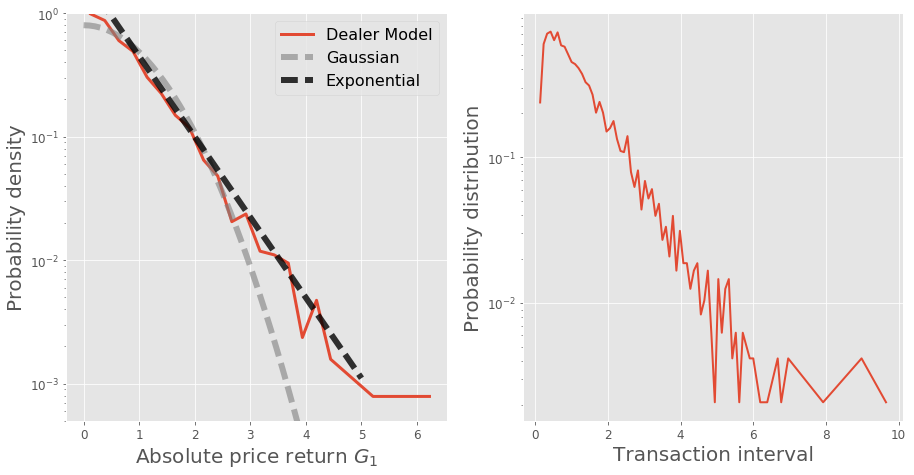

In [11]:
fig,[ax,bx]=plt.subplots(figsize=(15,7.5),ncols=2,subplot_kw={'ylabel':r'Probability distribution'})

edges,hist=pdf(np.abs(dprice),bins=25) # probability density of price change G_1 between ticks
ax.plot(edges, hist, lw=3, label='Dealer Model')

x = np.linspace(0, 5)

ax.plot(x,2*np.exp(-x**2/2)/np.sqrt(2*np.pi),lw=6,ls='--',color='gray',alpha=0.6,label=r'Gaussian')
ax.plot(x, 2*np.exp(-1.5*x),lw=6,color='k',ls='--',alpha=0.8,label=r'Exponential')

ax.set_xlabel(r'Absolute price return $G_1$')
ax.set_ylabel(r'Probability density')
ax.set_ylim([5e-4,1])
ax.semilogy()
ax.legend()

edges,hist=pdf(timeinterval,bins=100) # probability density of transaction time intervals between ticks

bx.plot(edges,hist, lw=2)
bx.set_xlabel(r'Transaction interval')
bx.set_ylabel(r'Probability distribution')
bx.semilogy()

plt.show()

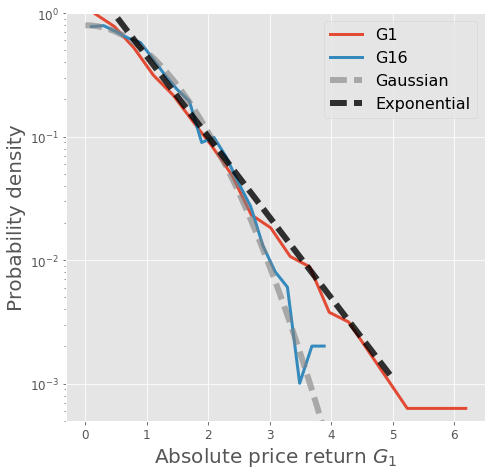

In [16]:
dprice16=normalized(logreturn(mktprice,16)) # compute logarithmic return of the price over one tick, normalized to have unit variance (Eq. J2)

fig,ax=plt.subplots(figsize=(7.5,7.5),ncols=1,subplot_kw={'ylabel':r'Probability distribution'})

edges,hist=pdf(np.abs(dprice),bins=20) # probability density of price change G_1 between ticks
edges16,hist16=pdf(np.abs(dprice16),bins=20) # probability density of price change G_16 between ticks

ax.plot(edges, hist, lw=3, label='G1')
ax.plot(edges16, hist16, lw=3, label='G16')

x = np.linspace(0, 5)

ax.plot(x,2*np.exp(-x**2/2)/np.sqrt(2*np.pi),lw=6,ls='--',color='gray',alpha=0.6,label=r'Gaussian')
ax.plot(x, 2*np.exp(-1.5*x),lw=6,color='k',ls='--',alpha=0.8,label=r'Exponential')

ax.set_xlabel(r'Absolute price return $G_1$')
ax.set_ylabel(r'Probability density')
ax.set_ylim([5e-4,1])
ax.semilogy()
ax.legend()


plt.show()